In [192]:
# Homework 4 (due 07/24/2024)

# CREDIT: Kyrylo Bakumenko

# Decision trees, interpretability, and algorithmic bias

## Objective

In this week's project, you will explore the COMPAS data set. COMPAS stands for "Correctional Offender Management Profiling for Alternative Sanctions". It is a software/algorithm that is used to assess the risk of a registered offender is going to commit another offense. Although researchers and journalists have pointed to [various problems](https://www.propublica.org/article/machine-bias-risk-assessments-in-criminal-sentencing) of this algorithm over many years, the algorithm is still used to inform sentences and parole decisions in several US states.
You can learn more about the COMPAS data set [here](https://www.propublica.org/datastore/dataset/compas-recidivism-risk-score-data-and-analysis).

Through this project, you will practice fitting and validating several classification models and you will explore some distinct benefits of using decision trees in machine learning. As part of that exploration, you are going to audit your model for demographic biases via a "closed box" and an "open box" approach.

The COMPAS data set is a favorite example among critics of machine learning because it demonstrates several shortcomings and failure modes of machine learning techniques. The lessons learned from this project might be discouraging, and they are important. Keep in mind, however, that what you see here does not generalize to all data sets.

This project has four parts.

### Part 1: Prepare the COMPAS data set  (PARTIALLY YOU TO COMPLETE)

In this part, you will load the COMPAS data set, explore its content, and select several variables as features (i.e., queries) or class labels (i.e., responses). Some of these features are not numerical, so you will need to replace some categorical values with zeros and ones. Your features will include categorical variable with more than two categories. You will uses 1-hot encoding to include this feature in your data set.

This part includes four steps:
1. Load and explore data set
2. Select features and response variables
3. Construct numerical coding for categorical features
4. Split the data

### Part 2: Train and validate a decision tree  (PARTIALLY YOU TO COMPLETE)

In this part, you will fit a decision tree to your data. You will examine the effect of tuning the complexity of the tree via the "maximum number of leaves" parameter and use 5-fold cross-validation to find an optimal value.

This part includes three steps:

1. Fit a decision tree on the training data
2. Tune the parameter "maximum number of leaves"
3. Calculate the selected model's test performance


### Part 3: Auditing a decision tree for demographic biases  (PARTIALLY YOU TO COMPLETE)

Your training data includes several demographic variables (i.e., age, sex, race). A crude way to assess whether a model has some demographic bias is to remove the corresponding variables from your training data and explore how that removal affects your model's performance. Decision trees have the advantage of being interpretable machine learning models. By going through the decision nodes (i.e., branching points), you can "open the black box and look inside". Specifically, you can assess how each feature is used in the decision making process.

This part includes three steps:

1. Fit a decision tree
2. Check for racial bias via performance assessment
3. Check for racial bias via decision rules

### Part 4: Comparison to other linear classifiers (FOR YOU TO COMPLETE)

For some types of data, decision trees tend to achieve lower prediction accuracies In this part, you will train and tune several classifiers on the COMPAS data. You will then compare their performance on your test set.

This part includes three steps:

1. Fit LDA and logistic regression
2. Tune and fit ensemble methods
3. Tune and fit SVC
4. Compare performance metrics for all models

In [193]:
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.tree import DecisionTreeClassifier, export_text
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier, GradientBoostingClassifier
from sklearn.svm import SVC

## Part 1: Prepare the COMPAS data set

>In this part, you will load the COMPAS data set, explore its content, and select several variables as features (i.e., queries) or class labels (i.e., responses). Some of these features are not numerical, so you will need to replace some categorical values with zeros and ones. Your features will include categorical variable with more than two categories. You will uses 1-hot encoding to include this feature in your data set.
>
>This part includes four steps:
>1. Load and explore data set
>2. Select features and response variables
>3. Construct numerical coding for categorical features
>4. Split the data



### Part 1, Step 1: Load and explore data set

This folder includes the 'compas-scores-two-years.csv' file. The COMPAS data that you will use for this project is in this file. It is always a good idea to look at the raw data before proceeding with one's machine learning pipeline.

In [194]:
# load data
raw_data = pd.read_csv('compas-scores-two-years.csv')
# print a list of variable names
print(raw_data.columns)
# look at the first 5 rows
raw_data.head(5)

Index(['id', 'name', 'first', 'last', 'compas_screening_date', 'sex', 'dob',
       'age', 'age_cat', 'race', 'juv_fel_count', 'decile_score',
       'juv_misd_count', 'juv_other_count', 'priors_count',
       'days_b_screening_arrest', 'c_jail_in', 'c_jail_out', 'c_case_number',
       'c_offense_date', 'c_arrest_date', 'c_days_from_compas',
       'c_charge_degree', 'c_charge_desc', 'is_recid', 'r_case_number',
       'r_charge_degree', 'r_days_from_arrest', 'r_offense_date',
       'r_charge_desc', 'r_jail_in', 'r_jail_out', 'violent_recid',
       'is_violent_recid', 'vr_case_number', 'vr_charge_degree',
       'vr_offense_date', 'vr_charge_desc', 'type_of_assessment',
       'decile_score.1', 'score_text', 'screening_date',
       'v_type_of_assessment', 'v_decile_score', 'v_score_text',
       'v_screening_date', 'in_custody', 'out_custody', 'priors_count.1',
       'start', 'end', 'event', 'two_year_recid'],
      dtype='object')


,id,name,first,last,compas_screening_date,sex,dob,age,age_cat,race,...,v_decile_score,v_score_text,v_screening_date,in_custody,out_custody,priors_count.1,start,end,event,two_year_recid
0,1,miguel hernandez,miguel,hernandez,2013-08-14,Male,1947-04-18,69,Greater than 45,Other,...,1,Low,2013-08-14,2014-07-07,2014-07-14,0,0,327,0,0
1,3,kevon dixon,kevon,dixon,2013-01-27,Male,1982-01-22,34,25 - 45,African-American,...,1,Low,2013-01-27,2013-01-26,2013-02-05,0,9,159,1,1
2,4,ed philo,ed,philo,2013-04-14,Male,1991-05-14,24,Less than 25,African-American,...,3,Low,2013-04-14,2013-06-16,2013-06-16,4,0,63,0,1
3,5,marcu brown,marcu,brown,2013-01-13,Male,1993-01-21,23,Less than 25,African-American,...,6,Medium,2013-01-13,NaN,NaN,1,0,1174,0,0
4,6,bouthy pierrelouis,bouthy,pierrelouis,2013-03-26,Male,1973-01-22,43,25 - 45,Other,...,1,Low,2013-03-26,NaN,NaN,2,0,1102,0,0


The data set includes 53 variables. There are different types of information. Some variables
* personal data (e.g., name, first name ("first"), last name ("last"))
* demographic data (i.e., sex, age, age category ("age_cat"), and race)
* related to the person's history of commited offenses (e.g., juvenile felony count ("juv_fel_count"), juvenile misdemeanor count ("juv_misd_count"), and prior offenses count ("priors-count"))
* related to the charge against the person (e.g., charge offense date ("c_offense_date"), charge arrest date ("c_arrest_date"), charge degree ("c_charge_degree"), and description of charge ("c_charge_desc"))
* recidivism scores assigned by the COMPAS algorithm (e.g., "decile_score", "score_text", "v_decile_score", "v_score_text")
* related to an actual recidivism charge (e.g., degree of recidivism charge ("r_charge_degree"), data of recidivism offense ("r_offense_date"), description of recidivism charge ("r_charge_desc"))
* related to an actual violent recidivism charge (e.g., degree of violent recidivism charge ("vr_charge_degree"), data of violent recidivism offense ("vr_offense_date"), description of violent recidivism charge ("vr_charge_desc")).

### Part 1, Step 2: Select features and response variables

The ProPublica article was assessing bias in the COMPAS scores. Here, you will ignore the COMPAS scores and instead explore the challenges of predicting recidivism based on the survey data. What variables seem like sensible predictors? What variables would be sensible outcome variables? The code in the cell below selects some numerical and categorical variables for you to include in your model.

In [195]:
# Select features and response variables

# Features by type
numerical_features = ['juv_misd_count', 'juv_other_count', 'juv_fel_count',
    'priors_count', 'age']
binary_categorical_features = ['sex', 'c_charge_degree']
other_categorical_features = ['race']
all_features = binary_categorical_features + other_categorical_features + numerical_features

# Possible esponse variables
response_variables = ['is_recid', 'is_violent_recid', 'two_year_recid']

# Variables that are used for data cleaning
check_variables = ['days_b_screening_arrest']

ProPublica filtered some observations (i.e., rows in the data frame). See their explanation below. Let's follow their procedure.


> There are a number of reasons remove rows because of missing data:
>
> * If the charge date of a defendants Compas scored crime was not within 30 days from when the person was arrested, we assume that because of data quality reasons, that we do not have the right offense.
> * We coded the recidivist flag -- is_recid -- to be -1 if we could not find a compas case at all.
> * In a similar vein, ordinary traffic offenses -- those with a c_charge_degree of 'O' -- will not result in Jail time are removed (only two of them).
> * We filtered the underlying data from Broward county to include only those rows representing people who had either recidivated in two years, or had at least two years outside of a correctional facility.


In [196]:
# Subselect data
df = raw_data[all_features+response_variables+check_variables]

# Apply filters
df = df[(df['days_b_screening_arrest'] <= 30) &
        (df['days_b_screening_arrest'] >= -30) &
        (df['is_recid'] != -1) &
        (df['c_charge_degree'] != 'O')]

df = df[all_features+response_variables]
print('Dataframe has {} rows and {} columns.'.format(df.shape[0], df.shape[1]))

Dataframe has 6172 rows and 11 columns.


### Part 1, Step 3: Construct numerical coding for categorical features

Some of these features in the subselected data are not numerical, so you will need to replace some categorical values with zeros and ones. Your features will include "race", which was surveyed as a one categorical variable with more than two categories. You will uses [1-hot encoding](https://en.wikipedia.org/wiki/One-hot) to include this feature in your data set.

In [197]:
# Code binary features as 0 and 1
for x in binary_categorical_features:
    for new_value, value in enumerate(set(df[x])):
        print("Replace {} with {}.".format(value, new_value))
        df = df.replace(value, new_value)

Replace Female with 0.
Replace Male with 1.
Replace F with 0.
Replace M with 1.


In [198]:
# Use 1-hot encoding for other categorical variables
one_hot_features = []
for x in other_categorical_features:
    for new_feature, value in enumerate(set(df[x])):
        feature_name = "{}_is_{}".format(x,value)
        df.insert(3, feature_name, df[x]==value)
        one_hot_features += [feature_name]

# Check what the data frame looks like now
df.head(10)

,sex,c_charge_degree,race,race_is_Asian,race_is_Caucasian,race_is_Other,race_is_Native American,race_is_Hispanic,race_is_African-American,juv_misd_count,juv_other_count,juv_fel_count,priors_count,age,is_recid,is_violent_recid,two_year_recid
0,1,0,Other,False,False,True,False,False,False,0,0,0,0,69,0,0,0
1,1,0,African-American,False,False,False,False,False,True,0,0,0,0,34,1,1,1
2,1,0,African-American,False,False,False,False,False,True,0,1,0,4,24,1,0,1
5,1,1,Other,False,False,True,False,False,False,0,0,0,0,44,0,0,0
6,1,0,Caucasian,False,True,False,False,False,False,0,0,0,14,41,1,0,1
7,1,0,Other,False,False,True,False,False,False,0,0,0,3,43,0,0,0
8,0,1,Caucasian,False,True,False,False,False,False,0,0,0,0,39,0,0,0
10,1,0,Caucasian,False,True,False,False,False,False,0,0,0,0,27,0,0,0
11,1,1,African-American,False,False,False,False,False,True,0,0,0,3,23,1,0,1
12,0,1,Caucasian,False,True,False,False,False,False,0,0,0,0,37,0,0,0


### Part 1, Step 4: Split the data

Let's collect the features in one data frame and the responses in another data frame. After that, you will set a small portion of the data set aside for testing.

In [199]:
# list of features
features = numerical_features + binary_categorical_features + one_hot_features

# features data frame
X = df[features]

# responses data frame
Y = df[response_variables]

# Split the data into a training set containing 90% of the data
# and test set containing 10% of the data
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.1, random_state=42)

# Part 2: Train and validate a decision tree

>In this part, you will fit a decision tree to your data. You will examine the effect of tuning the complexity of the tree via the "maximum number of leaves" parameter and use 5-fold cross-validation to find an optimal value.
>
>This part includes three steps:
>
>1. Fit a decision tree on the training data
>2. Tune the parameter "maximum number of leaves"
>3. Calculate the selected model's test performance

### Part 2, Step 1: Fit a decision tree on the training data

Start by fitting a decision tree to your training data. Assess its training accuracy and its size.

In [200]:
# Create a model
dtc = DecisionTreeClassifier()

# Fit model to training data
dtc.fit(X_train, Y_train['two_year_recid'])

# Evaluate training accuracy
accuracy = dtc.score(X_train, Y_train['two_year_recid'])

# Check size of decision tree
num_leaves = dtc.get_n_leaves()

# Report results
print('Trained decision tree with {} leaves and training accuracy {:.2f}.'.format(num_leaves, accuracy))

Trained decision tree with 1749 leaves and training accuracy 0.84.


Your tree has a good training accuracy for the standards of tabular data prediction problems, but its size is enormous! It has so many leaves, that on average every 3 to 4 training observations get a leaf to themselves. It is very probable that this tree is overfitting.

### Part 2, Step 2: Tune the parameter "maximum number of leaves"

Let's try to constrain the complexity of a decision tree during training by setting a value for the argument ``maximum number of leaves``. You can use the sci-kit learn's `cross_val_score` function to quickly assess the out-of-sample performance of trees of varying complexity.

In [201]:
# Perform 5-fold cross-validation for different tree sizes

print('Leaves\tMean accuracy')
print('---------------------')
best_score = 0
best_leaf_count = 0
for num_leaves in range(40,1800,10):

    # Trees must have at least 2 leaves
    if num_leaves >= 2:

        # construct a classifier with a limit on its number of leaves
        dtc = DecisionTreeClassifier(max_leaf_nodes = num_leaves)

        # Get validation accuracy via 5-fold cross-validation
        scores = cross_val_score(dtc, X_train, Y_train['two_year_recid'], cv=5)

    if scores.mean() > best_score:
        best_score = scores.mean()
        best_leaf_count = num_leaves

    if scores.mean() == best_score or num_leaves % 100 == 0:
        print("{}\t{:.3f}".format(num_leaves,scores.mean()))

Leaves	Mean accuracy
---------------------
40	0.673
100	0.665
200	0.654
300	0.650
400	0.643
500	0.641
600	0.636
700	0.635
800	0.631
900	0.631
1000	0.627
1100	0.630
1200	0.624
1300	0.625
1400	0.622
1500	0.624
1600	0.621
1700	0.624


Adjust the range of values for `max_leaf_nodes` in the cell above, to identify the best value.

### Part 2, Step 3: Calculate the selected model's test performance

Train a decision tree using your selected value of `max_leaf_nodes` on the full training set. Assess its accuracy on your test set.

In [202]:
# Create a model
dtc = DecisionTreeClassifier(max_leaf_nodes=best_leaf_count)

# Fit model to training data
dtc.fit(X_train, Y_train['two_year_recid'])

# Evaluate training accuracy
accuracy = dtc.score(X_train, Y_train['two_year_recid'])

# Check size of decision tree
num_leaves = dtc.get_n_leaves()

# Report results
print('Trained decision tree with {} leaves and test accuracy {:.2f}.'.format(num_leaves, accuracy))

Trained decision tree with 40 leaves and test accuracy 0.70.


# Part 3: Auditing a decision tree for demographic biases

>Your training data includes several demographic variables (i.e., age, sex, race). A crude way to assess whether a model has some demographic bias is to remove the corresponding variables from your training data and explore how that removal affects your model's performance. Decision trees have the advantage of being interpretable machine learning models. By going through the decision nodes (i.e., branching points), you can "open the black box and look inside". Specifically, you can assess how each feature is used in the decision making process.
>
>This part includes two steps:
>
>1. Check for racial bias via performance assessment
>2. Check for racial bias via decision rules
  
### Part 3, Step 2: Check for racial bias via performance assessment
A simple approach to identifying demographic biases in machine learning is the following: (i) Train and validate the model on the full training set, (ii) train and validate the model on a subset of training variables that excludes the variables related to a potential demographic bias, (iii) compare the results.

You have noticed that the validation accuracy of your model can vary for different holdout set selections. To account for these variations, you are going to compare the mean validation accuracy over 100 trees. (You have completed (i) in the previous cell already. Continue now with (ii).)

In [203]:
# Create subset of training data without information on race.
# (The information on race was encoded in the one-hot features.)
remaining_features = [v for v in X.columns if v not in one_hot_features]
X_train_sub = X_train[remaining_features]
X_test_sub = X_test[remaining_features]

# Create a model
dtc = DecisionTreeClassifier(max_leaf_nodes=best_leaf_count)

# Fit model to training data
dtc.fit(X_train_sub, Y_train['two_year_recid'])

# Evaluate train accuracy
Y_pred = dtc.predict(X_test_sub)
accuracy = (Y_pred == Y_test['two_year_recid']).mean()
# Evaluate test accuracy
Y_pred = dtc.predict(X_train_sub)
train_accuracy = (Y_pred == Y_train['two_year_recid']).mean()

# Check size of decision tree
num_leaves = dtc.get_n_leaves()

# Report results
print('Trained decision tree with {} leaves and training accuracy {:.2f}.'.format(num_leaves, train_accuracy))
print('Trained decision tree with {} leaves and test accuracy {:.2f}.'.format(num_leaves, accuracy))

Trained decision tree with 40 leaves and training accuracy 0.70.
Trained decision tree with 40 leaves and test accuracy 0.65.


# Over 100 trees:

In [204]:
# Parameters
num_splits = 100
test_size = 0.2

# To store validation accuracies
stored_accuracies = []

for n in range(num_splits):
    X_train_sub_split, X_test_sub_split, y_train_split, y_test_split = train_test_split(
        X_train_sub, Y_train['two_year_recid'], test_size=test_size, random_state=None
    )

    # Create and train a new deccision tree
    dtc = DecisionTreeClassifier(max_leaf_nodes=best_leaf_count)
    dtc.fit(X_train_sub_split, y_train_split)

    y_pred = dtc.predict(X_test_sub_split)

    accuracy = (y_pred == y_test_split)
    stored_accuracies.append(accuracy)

mean_accuracy = np.mean(stored_accuracies)
print(f'Mean accuracy over {num_splits} trees: {mean_accuracy:.4f}')

Mean accuracy over 100 trees: 0.6798


# Comparing to model WITH race

In [205]:
dtc = DecisionTreeClassifier()
dtc.fit(X_train, Y_train['two_year_recid'])

# Evaluate train accuracy
Y_pred = dtc.predict(X_test)
accuracy = (Y_pred == Y_test['two_year_recid']).mean()
# Evaluate test accuracy
Y_pred = dtc.predict(X_train)
train_accuracy = (Y_pred == Y_train['two_year_recid']).mean()

# Check size of decision tree
num_leaves = dtc.get_n_leaves()

# Report results
print('Trained decision tree with {} leaves and training accuracy {:.2f}.'.format(num_leaves, train_accuracy))
print('Trained decision tree with {} leaves and test accuracy {:.2f}.'.format(num_leaves, accuracy))

Trained decision tree with 1752 leaves and training accuracy 0.84.
Trained decision tree with 1752 leaves and test accuracy 0.62.


In [206]:
# Parameters
num_splits = 100
test_size = 0.2

# To store validation accuracies
stored_accuracies = []

for n in range(num_splits):
    X_train_split, X_test_split, y_train_split, y_test_split = train_test_split(
        X_train, Y_train['two_year_recid'], test_size=test_size, random_state=None
    )

    # Create and train a new deccision tree
    dtc = DecisionTreeClassifier(max_leaf_nodes=best_leaf_count)
    dtc.fit(X_train_split, y_train_split)

    y_pred = dtc.predict(X_test_split)

    accuracy = (y_pred == y_test_split)
    stored_accuracies.append(accuracy)

mean_accuracy = np.mean(stored_accuracies)
print(f'Mean accuracy over {num_splits} trees: {mean_accuracy:.4f}')

Mean accuracy over 100 trees: 0.6800


Comparing the mean accuracy values on the all features versus the subselected feature set, what do you conclude about the importance of racial information in this classification problem?

## Analysis
From the results it initially seemed like racial data was helpfulf or the model to make classifications, due to the increased training accuracy. However, after further testing, means across many trees, and consider *testing* accuracy that is unseen, there seems little to no difference in accuracy. From this, I conclude that the model uses race as yet another feature, allowing to slightly overfit (benefit the training accuracy) without benfiting the generalization of the problem (testing accuracy).

### Part 2, Step 3: Check for racial bias via decision rules
The interpretability of decision trees allows for an alternative approach to detecting racial bias. You can simply look at the decision rules. Use the scit-kit learn's function `export_text` to get your decision tree in text format. Compare the decision rules of the your tree with all features and your tree fitted on the subset without racial information. Do you find any indication of racial bias in the decision rules of the first tree?

In [207]:
# racial features
print(one_hot_features)

['race_is_African-American', 'race_is_Hispanic', 'race_is_Native American', 'race_is_Other', 'race_is_Caucasian', 'race_is_Asian']


In [208]:
dtc_full = DecisionTreeClassifier(max_leaf_nodes = best_leaf_count)

# Fit model to training data
dtc_full.fit(X_train, Y_train['two_year_recid'])
feature_names = list(X.columns)
export_text(dtc_full, feature_names = feature_names)

'|--- priors_count <= 2.50\n|   |--- age <= 22.50\n|   |   |--- age <= 20.50\n|   |   |   |--- priors_count <= 0.50\n|   |   |   |   |--- age <= 19.50\n|   |   |   |   |   |--- class: 1\n|   |   |   |   |--- age >  19.50\n|   |   |   |   |   |--- juv_other_count <= 1.50\n|   |   |   |   |   |   |--- class: 1\n|   |   |   |   |   |--- juv_other_count >  1.50\n|   |   |   |   |   |   |--- class: 0\n|   |   |   |--- priors_count >  0.50\n|   |   |   |   |--- class: 1\n|   |   |--- age >  20.50\n|   |   |   |--- sex <= 0.50\n|   |   |   |   |--- class: 0\n|   |   |   |--- sex >  0.50\n|   |   |   |   |--- priors_count <= 1.50\n|   |   |   |   |   |--- race_is_Caucasian <= 0.50\n|   |   |   |   |   |   |--- class: 1\n|   |   |   |   |   |--- race_is_Caucasian >  0.50\n|   |   |   |   |   |   |--- class: 0\n|   |   |   |   |--- priors_count >  1.50\n|   |   |   |   |   |--- class: 1\n|   |--- age >  22.50\n|   |   |--- priors_count <= 0.50\n|   |   |   |--- age <= 52.50\n|   |   |   |   |---

# Full Tree
\

```
|--- priors_count <= 2.50
|   |--- age <= 22.50
|   |   |--- age <= 20.50
|   |   |   |--- priors_count <= 0.50
|   |   |   |   |--- age <= 19.50
|   |   |   |   |   |--- class: 1
|   |   |   |   |--- age >  19.50
|   |   |   |   |   |--- juv_other_count <= 1.50
|   |   |   |   |   |   |--- sex <= 0.50
|   |   |   |   |   |   |   |--- c_charge_degree <= 0.50
|   |   |   |   |   |   |   |   |--- class: 0
|   |   |   |   |   |   |   |--- c_charge_degree >  0.50
|   |   |   |   |   |   |   |   |--- class: 1
|   |   |   |   |   |   |--- sex >  0.50
|   |   |   |   |   |   |   |--- class: 1
|   |   |   |   |   |--- juv_other_count >  1.50
|   |   |   |   |   |   |--- race_is_African-American <= 0.50
|   |   |   |   |   |   |   |--- class: 0
|   |   |   |   |   |   |--- race_is_African-American >  0.50
|   |   |   |   |   |   |   |--- class: 1
|   |   |   |--- priors_count >  0.50
|   |   |   |   |--- race_is_Other <= 0.50
|   |   |   |   |   |--- class: 1
|   |   |   |   |--- race_is_Other >  0.50
|   |   |   |   |   |--- sex <= 0.50
|   |   |   |   |   |   |--- class: 0
|   |   |   |   |   |--- sex >  0.50
|   |   |   |   |   |   |--- class: 1
|   |   |--- age >  20.50
|   |   |   |--- sex <= 0.50
|   |   |   |   |--- class: 0
|   |   |   |--- sex >  0.50
|   |   |   |   |--- priors_count <= 1.50
|   |   |   |   |   |--- race_is_Caucasian <= 0.50
|   |   |   |   |   |   |--- priors_count <= 0.50
|   |   |   |   |   |   |   |--- juv_other_count <= 1.50
|   |   |   |   |   |   |   |   |--- class: 1
|   |   |   |   |   |   |   |--- juv_other_count >  1.50
|   |   |   |   |   |   |   |   |--- class: 1
|   |   |   |   |   |   |--- priors_count >  0.50
|   |   |   |   |   |   |   |--- juv_other_count <= 1.50
|   |   |   |   |   |   |   |   |--- age <= 21.50
|   |   |   |   |   |   |   |   |   |--- class: 1
|   |   |   |   |   |   |   |   |--- age >  21.50
|   |   |   |   |   |   |   |   |   |--- juv_fel_count <= 0.50
|   |   |   |   |   |   |   |   |   |   |--- race_is_Asian <= 0.50
|   |   |   |   |   |   |   |   |   |   |   |--- class: 1
|   |   |   |   |   |   |   |   |   |   |--- race_is_Asian >  0.50
|   |   |   |   |   |   |   |   |   |   |   |--- class: 0
|   |   |   |   |   |   |   |   |   |--- juv_fel_count >  0.50
|   |   |   |   |   |   |   |   |   |   |--- class: 0
|   |   |   |   |   |   |   |--- juv_other_count >  1.50
|   |   |   |   |   |   |   |   |--- juv_fel_count <= 0.50
|   |   |   |   |   |   |   |   |   |--- class: 0
|   |   |   |   |   |   |   |   |--- juv_fel_count >  0.50
|   |   |   |   |   |   |   |   |   |--- class: 1
|   |   |   |   |   |--- race_is_Caucasian >  0.50
|   |   |   |   |   |   |--- class: 0
|   |   |   |   |--- priors_count >  1.50
|   |   |   |   |   |--- class: 1
|   |--- age >  22.50
|   |   |--- priors_count <= 0.50
|   |   |   |--- age <= 52.50
|   |   |   |   |--- sex <= 0.50
|   |   |   |   |   |--- c_charge_degree <= 0.50
|   |   |   |   |   |   |--- race_is_Other <= 0.50
|   |   |   |   |   |   |   |--- class: 0
|   |   |   |   |   |   |--- race_is_Other >  0.50
|   |   |   |   |   |   |   |--- class: 0
|   |   |   |   |   |--- c_charge_degree >  0.50
|   |   |   |   |   |   |--- age <= 26.50
|   |   |   |   |   |   |   |--- class: 0
|   |   |   |   |   |   |--- age >  26.50
|   |   |   |   |   |   |   |--- class: 0
|   |   |   |   |--- sex >  0.50
|   |   |   |   |   |--- age <= 28.50
|   |   |   |   |   |   |--- class: 0
|   |   |   |   |   |--- age >  28.50
|   |   |   |   |   |   |--- c_charge_degree <= 0.50
|   |   |   |   |   |   |   |--- class: 0
|   |   |   |   |   |   |--- c_charge_degree >  0.50
|   |   |   |   |   |   |   |--- age <= 51.50
|   |   |   |   |   |   |   |   |--- class: 0
|   |   |   |   |   |   |   |--- age >  51.50
|   |   |   |   |   |   |   |   |--- race_is_Caucasian <= 0.50
|   |   |   |   |   |   |   |   |   |--- class: 1
|   |   |   |   |   |   |   |   |--- race_is_Caucasian >  0.50
|   |   |   |   |   |   |   |   |   |--- class: 0
|   |   |   |--- age >  52.50
|   |   |   |   |--- class: 0
|   |   |--- priors_count >  0.50
|   |   |   |--- age <= 32.50
|   |   |   |   |--- priors_count <= 1.50
|   |   |   |   |   |--- race_is_Hispanic <= 0.50
|   |   |   |   |   |   |--- sex <= 0.50
|   |   |   |   |   |   |   |--- age <= 30.50
|   |   |   |   |   |   |   |   |--- class: 0
|   |   |   |   |   |   |   |--- age >  30.50
|   |   |   |   |   |   |   |   |--- class: 1
|   |   |   |   |   |   |--- sex >  0.50
|   |   |   |   |   |   |   |--- age <= 26.50
|   |   |   |   |   |   |   |   |--- class: 0
|   |   |   |   |   |   |   |--- age >  26.50
|   |   |   |   |   |   |   |   |--- race_is_African-American <= 0.50
|   |   |   |   |   |   |   |   |   |--- age <= 29.50
|   |   |   |   |   |   |   |   |   |   |--- age <= 28.50
|   |   |   |   |   |   |   |   |   |   |   |--- class: 0
|   |   |   |   |   |   |   |   |   |   |--- age >  28.50
|   |   |   |   |   |   |   |   |   |   |   |--- class: 0
|   |   |   |   |   |   |   |   |   |--- age >  29.50
|   |   |   |   |   |   |   |   |   |   |--- class: 1
|   |   |   |   |   |   |   |   |--- race_is_African-American >  0.50
|   |   |   |   |   |   |   |   |   |--- c_charge_degree <= 0.50
|   |   |   |   |   |   |   |   |   |   |--- class: 0
|   |   |   |   |   |   |   |   |   |--- c_charge_degree >  0.50
|   |   |   |   |   |   |   |   |   |   |--- class: 0
|   |   |   |   |   |--- race_is_Hispanic >  0.50
|   |   |   |   |   |   |--- class: 0
|   |   |   |   |--- priors_count >  1.50
|   |   |   |   |   |--- sex <= 0.50
|   |   |   |   |   |   |--- c_charge_degree <= 0.50
|   |   |   |   |   |   |   |--- class: 1
|   |   |   |   |   |   |--- c_charge_degree >  0.50
|   |   |   |   |   |   |   |--- class: 0
|   |   |   |   |   |--- sex >  0.50
|   |   |   |   |   |   |--- age <= 24.50
|   |   |   |   |   |   |   |--- race_is_African-American <= 0.50
|   |   |   |   |   |   |   |   |--- class: 0
|   |   |   |   |   |   |   |--- race_is_African-American >  0.50
|   |   |   |   |   |   |   |   |--- class: 1
|   |   |   |   |   |   |--- age >  24.50
|   |   |   |   |   |   |   |--- juv_misd_count <= 0.50
|   |   |   |   |   |   |   |   |--- class: 0
|   |   |   |   |   |   |   |--- juv_misd_count >  0.50
|   |   |   |   |   |   |   |   |--- class: 1
|   |   |   |--- age >  32.50
|   |   |   |   |--- age <= 38.50
|   |   |   |   |   |--- sex <= 0.50
|   |   |   |   |   |   |--- class: 0
|   |   |   |   |   |--- sex >  0.50
|   |   |   |   |   |   |--- age <= 36.50
|   |   |   |   |   |   |   |--- class: 0
|   |   |   |   |   |   |--- age >  36.50
|   |   |   |   |   |   |   |--- race_is_Hispanic <= 0.50
|   |   |   |   |   |   |   |   |--- class: 1
|   |   |   |   |   |   |   |--- race_is_Hispanic >  0.50
|   |   |   |   |   |   |   |   |--- class: 0
|   |   |   |   |--- age >  38.50
|   |   |   |   |   |--- age <= 75.50
|   |   |   |   |   |   |--- class: 0
|   |   |   |   |   |--- age >  75.50
|   |   |   |   |   |   |--- race_is_Caucasian <= 0.50
|   |   |   |   |   |   |   |--- class: 1
|   |   |   |   |   |   |--- race_is_Caucasian >  0.50
|   |   |   |   |   |   |   |--- class: 0
|--- priors_count >  2.50
|   |--- age <= 33.50
|   |   |--- priors_count <= 8.50
|   |   |   |--- age <= 27.50
|   |   |   |   |--- c_charge_degree <= 0.50
|   |   |   |   |   |--- race_is_African-American <= 0.50
|   |   |   |   |   |   |--- class: 1
|   |   |   |   |   |--- race_is_African-American >  0.50
|   |   |   |   |   |   |--- priors_count <= 3.50
|   |   |   |   |   |   |   |--- age <= 21.50
|   |   |   |   |   |   |   |   |--- class: 1
|   |   |   |   |   |   |   |--- age >  21.50
|   |   |   |   |   |   |   |   |--- class: 1
|   |   |   |   |   |   |--- priors_count >  3.50
|   |   |   |   |   |   |   |--- class: 1
|   |   |   |   |--- c_charge_degree >  0.50
|   |   |   |   |   |--- age <= 25.50
|   |   |   |   |   |   |--- juv_other_count <= 1.50
|   |   |   |   |   |   |   |--- juv_other_count <= 0.50
|   |   |   |   |   |   |   |   |--- class: 1
|   |   |   |   |   |   |   |--- juv_other_count >  0.50
|   |   |   |   |   |   |   |   |--- class: 1
|   |   |   |   |   |   |--- juv_other_count >  1.50
|   |   |   |   |   |   |   |--- class: 0
|   |   |   |   |   |--- age >  25.50
|   |   |   |   |   |   |--- priors_count <= 3.50
|   |   |   |   |   |   |   |--- class: 0
|   |   |   |   |   |   |--- priors_count >  3.50
|   |   |   |   |   |   |   |--- priors_count <= 4.50
|   |   |   |   |   |   |   |   |--- class: 1
|   |   |   |   |   |   |   |--- priors_count >  4.50
|   |   |   |   |   |   |   |   |--- age <= 26.50
|   |   |   |   |   |   |   |   |   |--- priors_count <= 7.50
|   |   |   |   |   |   |   |   |   |   |--- class: 0
|   |   |   |   |   |   |   |   |   |--- priors_count >  7.50
|   |   |   |   |   |   |   |   |   |   |--- class: 1
|   |   |   |   |   |   |   |   |--- age >  26.50
|   |   |   |   |   |   |   |   |   |--- class: 1
|   |   |   |--- age >  27.50
|   |   |   |   |--- priors_count <= 5.50
|   |   |   |   |   |--- sex <= 0.50
|   |   |   |   |   |   |--- race_is_African-American <= 0.50
|   |   |   |   |   |   |   |--- juv_other_count <= 0.50
|   |   |   |   |   |   |   |   |--- class: 1
|   |   |   |   |   |   |   |--- juv_other_count >  0.50
|   |   |   |   |   |   |   |   |--- class: 0
|   |   |   |   |   |   |--- race_is_African-American >  0.50
|   |   |   |   |   |   |   |--- class: 0
|   |   |   |   |   |--- sex >  0.50
|   |   |   |   |   |   |--- class: 1
|   |   |   |   |--- priors_count >  5.50
|   |   |   |   |   |--- race_is_Caucasian <= 0.50
|   |   |   |   |   |   |--- c_charge_degree <= 0.50
|   |   |   |   |   |   |   |--- juv_fel_count <= 1.50
|   |   |   |   |   |   |   |   |--- age <= 31.50
|   |   |   |   |   |   |   |   |   |--- class: 1
|   |   |   |   |   |   |   |   |--- age >  31.50
|   |   |   |   |   |   |   |   |   |--- priors_count <= 7.50
|   |   |   |   |   |   |   |   |   |   |--- class: 1
|   |   |   |   |   |   |   |   |   |--- priors_count >  7.50
|   |   |   |   |   |   |   |   |   |   |--- class: 0
|   |   |   |   |   |   |   |--- juv_fel_count >  1.50
|   |   |   |   |   |   |   |   |--- class: 0
|   |   |   |   |   |   |--- c_charge_degree >  0.50
|   |   |   |   |   |   |   |--- race_is_Asian <= 0.50
|   |   |   |   |   |   |   |   |--- class: 1
|   |   |   |   |   |   |   |--- race_is_Asian >  0.50
|   |   |   |   |   |   |   |   |--- class: 0
|   |   |   |   |   |--- race_is_Caucasian >  0.50
|   |   |   |   |   |   |--- age <= 29.50
|   |   |   |   |   |   |   |--- class: 1
|   |   |   |   |   |   |--- age >  29.50
|   |   |   |   |   |   |   |--- c_charge_degree <= 0.50
|   |   |   |   |   |   |   |   |--- class: 1
|   |   |   |   |   |   |   |--- c_charge_degree >  0.50
|   |   |   |   |   |   |   |   |--- class: 0
|   |   |--- priors_count >  8.50
|   |   |   |--- race_is_Asian <= 0.50
|   |   |   |   |--- class: 1
|   |   |   |--- race_is_Asian >  0.50
|   |   |   |   |--- class: 0
|   |--- age >  33.50
|   |   |--- priors_count <= 6.50
|   |   |   |--- age <= 55.50
|   |   |   |   |--- priors_count <= 4.50
|   |   |   |   |   |--- race_is_Hispanic <= 0.50
|   |   |   |   |   |   |--- age <= 52.50
|   |   |   |   |   |   |   |--- age <= 43.50
|   |   |   |   |   |   |   |   |--- class: 0
|   |   |   |   |   |   |   |--- age >  43.50
|   |   |   |   |   |   |   |   |--- class: 0
|   |   |   |   |   |   |--- age >  52.50
|   |   |   |   |   |   |   |--- class: 1
|   |   |   |   |   |--- race_is_Hispanic >  0.50
|   |   |   |   |   |   |--- class: 1
|   |   |   |   |--- priors_count >  4.50
|   |   |   |   |   |--- juv_fel_count <= 0.50
|   |   |   |   |   |   |--- class: 1
|   |   |   |   |   |--- juv_fel_count >  0.50
|   |   |   |   |   |   |--- class: 0
|   |   |   |--- age >  55.50
|   |   |   |   |--- class: 0
|   |   |--- priors_count >  6.50
|   |   |   |--- priors_count <= 15.50
|   |   |   |   |--- juv_other_count <= 0.50
|   |   |   |   |   |--- age <= 59.50
|   |   |   |   |   |   |--- juv_misd_count <= 2.50
|   |   |   |   |   |   |   |--- class: 1
|   |   |   |   |   |   |--- juv_misd_count >  2.50
|   |   |   |   |   |   |   |--- class: 0
|   |   |   |   |   |--- age >  59.50
|   |   |   |   |   |   |--- sex <= 0.50
|   |   |   |   |   |   |   |--- priors_count <= 13.00
|   |   |   |   |   |   |   |   |--- class: 1
|   |   |   |   |   |   |   |--- priors_count >  13.00
|   |   |   |   |   |   |   |   |--- class: 0
|   |   |   |   |   |   |--- sex >  0.50
|   |   |   |   |   |   |   |--- class: 0
|   |   |   |   |--- juv_other_count >  0.50
|   |   |   |   |   |--- class: 1
|   |   |   |--- priors_count >  15.50
|   |   |   |   |--- priors_count <= 27.50
|   |   |   |   |   |--- priors_count <= 26.50
|   |   |   |   |   |   |--- age <= 39.50
|   |   |   |   |   |   |   |--- juv_misd_count <= 2.50
|   |   |   |   |   |   |   |   |--- class: 1
|   |   |   |   |   |   |   |--- juv_misd_count >  2.50
|   |   |   |   |   |   |   |   |--- class: 0
|   |   |   |   |   |   |--- age >  39.50
|   |   |   |   |   |   |   |--- priors_count <= 21.50
|   |   |   |   |   |   |   |   |--- age <= 40.50
|   |   |   |   |   |   |   |   |   |--- class: 0
|   |   |   |   |   |   |   |   |--- age >  40.50
|   |   |   |   |   |   |   |   |   |--- class: 1
|   |   |   |   |   |   |   |--- priors_count >  21.50
|   |   |   |   |   |   |   |   |--- class: 1
|   |   |   |   |   |--- priors_count >  26.50
|   |   |   |   |   |   |--- c_charge_degree <= 0.50
|   |   |   |   |   |   |   |--- class: 1
|   |   |   |   |   |   |--- c_charge_degree >  0.50
|   |   |   |   |   |   |   |--- class: 0
|   |   |   |   |--- priors_count >  27.50
|   |   |   |   |   |--- class: 1
```



Race certianly plays a role in the models deicision making, with race_is_African_American appearing in 10 nodes alone (>0.5 or <= 0.5). Critically, in four of these decisions, whether the person is classified as CLASS 0 or CLASS 1 is *PURELY* decided by race_is_African_American's value. Making classifications, such as in those 4 nodes, purely on race is indeed racist. This highlights the fact that if models are not interpretable or are not carefully audited in sensitive areas, they can propogate racist trends.

# Part 4: Comparison to other linear classifiers

>For some types of data, decision trees tend to achieve lower prediction accuracies In this part, you will train and tune several classifiers on the COMPAS data. You will then compare their performance on your test set.
>
>This part includes three steps:
>
>1. Fit LDA and logistic regression
>2. Tune and fit ensemble methods
>3. Tune and fit SVC
>4. Compare test accuracy of all your models

In [209]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier, GradientBoostingClassifier
from sklearn.svm import SVC

# LDA & Logistic

In [210]:
# LDA
LDA_model = LinearDiscriminantAnalysis()
LDA_model.fit(X_train, Y_train['two_year_recid'])

# evaluate accuracy
y_pred = LDA_model.predict(X_test)
LDA_accuracy = (y_pred == Y_test['two_year_recid']).mean()

# LOGISTIC
logistic_model = LogisticRegression(max_iter=1000)
logistic_model.fit(X_train, Y_train['two_year_recid'])

# evaluate accuracy
y_pred = logistic_model.predict(X_test)
LOG_accuracy = (y_pred == Y_test['two_year_recid']).mean()

# Ensemble Methods

In [211]:
# RANDOM FOREST
rf_model = RandomForestClassifier(n_estimators=50)
rf_model.fit(X_train, Y_train['two_year_recid'])

# evaluate accuracy
y_pred = rf_model.predict(X_test)
RF_accuracy = (y_pred == Y_test['two_year_recid']).mean()

# BAGGING
bagging_model = BaggingClassifier(n_estimators=50)
bagging_model.fit(X_train, Y_train['two_year_recid'])

# evaluate accuracy
y_pred = bagging_model.predict(X_test)
BAG_accuracy = (y_pred == Y_test['two_year_recid']).mean()

# GRADIENT BOOSTING
gb = GradientBoostingClassifier()
gb.fit(X_train, Y_train['two_year_recid'])

y_pred = gb.predict(X_test)
accuracy_gb = gb.score(X_test, Y_test['two_year_recid'])

# SVC

In [212]:
# SVC
SVC_model = SVC()
SVC_model.fit(X_train, Y_train['two_year_recid'])

# evaluate accuracy
y_pred = SVC_model.predict(X_test)
SVC_accuracy = (y_pred == Y_test['two_year_recid']).mean()

In [213]:
# compare accuracy
print("LDA accuracy:", LDA_accuracy)
print("Logistic Regression accuracy:", LOG_accuracy)
print("SVC accuracy:", SVC_accuracy)
print("Random Forest accuracy:", RF_accuracy)
print("Bagging accuracy:", BAG_accuracy)
print("Gradient Boosting:", accuracy_gb)

LDA accuracy: 0.6601941747572816
Logistic Regression accuracy: 0.6650485436893204
SVC accuracy: 0.6796116504854369
Random Forest accuracy: 0.6375404530744336
Bagging accuracy: 0.6423948220064725
Gradient Boosting: 0.6521035598705501


In [214]:
scores = [mean_accuracy, LDA_accuracy, LOG_accuracy, SVC_accuracy, RF_accuracy, BAG_accuracy, accuracy_gb]

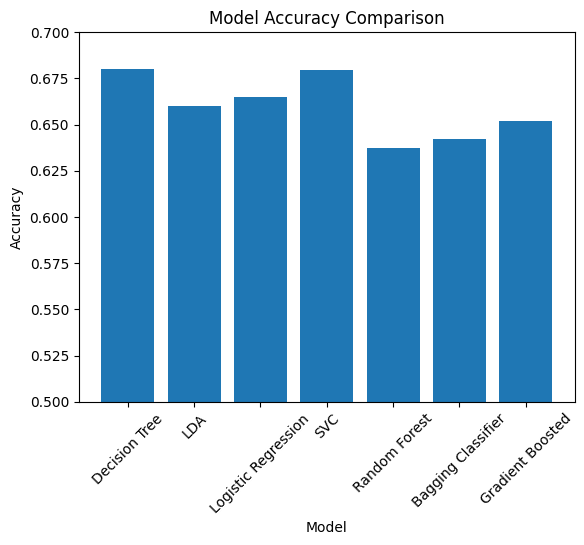

In [215]:
model_names = ['Decision Tree', 'LDA', 'Logistic Regression', 'SVC', 'Random Forest', 'Bagging Classifier', 'Gradient Boosted']

plt.bar(model_names, scores)
plt.title('Model Accuracy Comparison')
plt.ylabel('Accuracy')
plt.xlabel('Model')
plt.xticks(rotation=45)
plt.ylim(0.5, 0.7)
plt.show()